In [ ]:
pip install python-binance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.7 MB/s 
     |████████████████████████████████| 1.1 MB 10.7 MB/s 
     |████████████████████████████████| 288 kB 57.9 MB/s 
     |████████████████████████████████| 112 kB 63.4 MB/s 
     |████████████████████████████████| 45 kB 3.9 MB/s 
     |████████████████████████████████| 271 kB 56.8 MB/s 
     |████████████████████████████████| 144 kB 73.4 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 749 kB 49.7 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [ ]:
pip install websocket_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 1.9 MB/s 


In [ ]:
from binance.client import Client
from binance.enums import *
import time, datetime
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

import math
import numpy as np
from functools import reduce

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
import sklearn.metrics as metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# **data scraping**

**OHLC data:**
An OHLC chart is a type of bar chart that shows open, high, low, and closing prices for each period. 

In [ ]:
SOCKET = "wss://stream.binance.com:9443/ws/btcusdt@kline_1m"
TRADE_SYMBOL = 'BTCUSDT'
TRADE_SYMBOL_HISTORY = 'BTCUSDT'
API_KEY = 'ziew'
API_SECRET = 'ziew'

In [ ]:
client = Client(API_KEY, API_SECRET)#, tld='us')

In [ ]:

def GetHistoricalData(howLong):
    howLong = howLong
    # Calculate the timestamps for the binance api function
    untilThisDate = datetime.now()
    # sinceThisDate = untilThisDate - datetime.timedelta(days = howLong)
    sinceThisDate = untilThisDate - timedelta(hours = howLong)
    # Execute the query from binance - timestamps must be converted to strings !
    candle = client.get_historical_klines(TRADE_SYMBOL_HISTORY, Client.KLINE_INTERVAL_30MINUTE, str(sinceThisDate), str(untilThisDate))
    # print("TYPE", type(candle),"\n",candle)

    # Create a dataframe to label all the columns returned by binance so we work with them later.
    df = pd.DataFrame(candle, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'])
    # as timestamp is returned in ms, let us convert this back to proper timestamps.
    df.dateTime = pd.to_datetime(df.dateTime, unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')
    # df.set_index('dateTime', inplace=True)

    df["open"] = df.open.astype(float)
    df["high"] = df.high.astype(float)
    df["low"] = df.low.astype(float)
    df["close"] = df.close.astype(float)
    df["volume"] = df.volume.astype(float)

    # Get rid of columns we do not need
    df = df.drop(['quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol','takerBuyQuoteVol', 'ignore','closeTime'], axis=1)

    return df

In [ ]:
print("Launching script...")
df=GetHistoricalData(24*1100) # TAKE INTO ACCOUNT GMT-2 #1100 days

Launching script...


In [ ]:
df.tail()

,dateTime,open,high,low,close,volume
52700,2022-07-18 20:00:00,21617.92,21671.30,21505.62,21605.59,3108.11703
52701,2022-07-18 20:30:00,21607.27,21678.43,21434.35,21493.18,3501.63688
52702,2022-07-18 21:00:00,21491.79,21739.00,21445.25,21690.01,2877.25071
52703,2022-07-18 21:30:00,21692.08,21756.30,21625.58,21659.73,2203.09375
52704,2022-07-18 22:00:00,21660.90,21698.40,21577.76,21676.85,1101.99596


In [ ]:
df.shape

(52705, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52705 entries, 0 to 52704
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dateTime  52705 non-null  object 
 1   open      52705 non-null  float64
 2   high      52705 non-null  float64
 3   low       52705 non-null  float64
 4   close     52705 non-null  float64
 5   volume    52705 non-null  float64
dtypes: float64(5), object(1)
memory usage: 2.4+ MB


In [ ]:
include =['float', 'int']
df.describe(include = include)

,open,high,low,close,volume
count,52705.000000,52705.000000,52705.000000,52705.000000,52705.000000
mean,27201.622920,27310.313049,27087.375356,27201.827973,1361.920772
std,18335.884645,18411.101373,18256.880527,18335.759090,1464.825965
min,4131.230000,4258.530000,3782.130000,4130.640000,0.000000
25%,9586.310000,9609.910000,9560.000000,9586.440000,606.660845
50%,21401.730000,21484.470000,21327.520000,21407.030000,965.508134
75%,42935.390000,43090.040000,42765.260000,42935.400000,1583.151195
max,68635.120000,69000.000000,68462.960000,68633.690000,74378.715690


In [ ]:
#covert datatime column from object dtype to datetime dtype
df["dateTime"] = df.dateTime.astype('datetime64[ns]')

In [ ]:
#  rename close column to price column
df = df.rename({'close': 'price'}, axis='columns')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52705 entries, 0 to 52704
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   dateTime  52705 non-null  datetime64[ns]
 1   open      52705 non-null  float64       
 2   high      52705 non-null  float64       
 3   low       52705 non-null  float64       
 4   price     52705 non-null  float64       
 5   volume    52705 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 2.4 MB


In [ ]:
#Set time column as Index
df.set_index('dateTime',inplace=True)

In [ ]:
df.tail()

,open,high,low,price,volume
dateTime,,,,,
2022-07-18 20:00:00,21617.92,21671.30,21505.62,21605.59,3108.11703
2022-07-18 20:30:00,21607.27,21678.43,21434.35,21493.18,3501.63688
2022-07-18 21:00:00,21491.79,21739.00,21445.25,21690.01,2877.25071
2022-07-18 21:30:00,21692.08,21756.30,21625.58,21659.73,2203.09375
2022-07-18 22:00:00,21660.90,21698.40,21577.76,21676.85,1101.99596


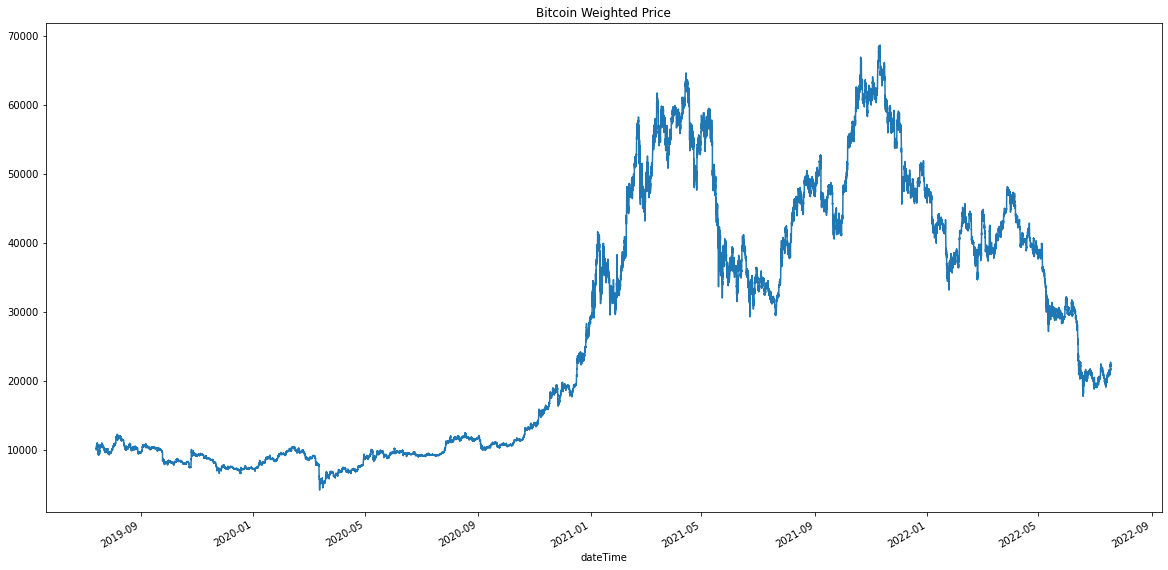

In [ ]:
#plot
df['price'].plot(title = "Bitcoin Weighted Price",x = "time",y = "price",figsize=(20, 10))
plt.show()

## **Auto-correlation**

In [ ]:
#Auto-correlation 
'''
plt.figure(figsize=(20,15))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(df['price'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(df['price'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(df['price'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(df['price'], lag=10080) #weekly lag
plt.title('Weekly Lag')
'''

"\nplt.figure(figsize=(20,15))\nplt.suptitle('Lag Plots', fontsize=22)\n\nplt.subplot(3,3,1)\npd.plotting.lag_plot(df['price'], lag=1) #minute lag\nplt.title('1-Minute Lag')\n\nplt.subplot(3,3,2)\npd.plotting.lag_plot(df['price'], lag=60) #hourley lag\nplt.title('1-Hour Lag')\n\nplt.subplot(3,3,3)\npd.plotting.lag_plot(df['price'], lag=1440) #Daily lag\nplt.title('Daily Lag')\n\nplt.subplot(3,3,4)\npd.plotting.lag_plot(df['price'], lag=10080) #weekly lag\nplt.title('Weekly Lag')\n"

In [ ]:
# Group by the day
'''
df['date'] = pd.to_datetime(df.index,unit='H').date
display(df.head())
group = df.groupby('date')
new_df = group['price'].mean()
display(new_df.head())
'''

"\ndf['date'] = pd.to_datetime(df.index,unit='H').date\ndisplay(df.head())\ngroup = df.groupby('date')\nnew_df = group['price'].mean()\ndisplay(new_df.head())\n"

In [ ]:
# Make a copy of the dataframe.
new_df = df.drop(["open", "high", "low", "volume"], axis=1)

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52705 entries, 2019-07-14 22:30:00 to 2022-07-18 22:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   52705 non-null  float64
dtypes: float64(1)
memory usage: 823.5 KB


## Data Split

we first need to split the data into training and test set before applying normalization over data.

In [ ]:
#  Train data  70%  
train = new_df[:int(new_df.shape[0]*0.7)].values
# cross validation data  15%
cv = new_df[int(new_df.shape[0]*0.7):int(new_df.shape[0]*0.85)].values
# Test data  15%
test = new_df[int(new_df.shape[0]*0.85):].values

In [ ]:
print(train.shape ,cv.shape , test.shape)

(36893, 1) (7906, 1) (7906, 1)


## Data Scaling

Standard Scaler for Data


we should perform feature normalisation over the training data. Then perform normalisation on testing instances as well, but this time using the mean and variance of training explanatory variables. In this way, we can test and evaluate whether our model can generalize well to new, unseen data points

In [ ]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
#scaled_train  = scaler.fit_transform(train)

scaler = scaler.fit(train)


scaled_train = scaler.transform(train)
scaled_cv   = scaler.transform(cv)
scaled_test   = scaler.transform(test)


In [ ]:
scaled_train[0:25]

array([[-0.60907402],
       [-0.61456556],
       [-0.62798129],
       [-0.6424049 ],
       [-0.63790866],
       [-0.63233517],
       [-0.63614534],
       [-0.63533486],
       [-0.63220597],
       [-0.62315608],
       [-0.62375662],
       [-0.62684243],
       [-0.62896584],
       [-0.63026799],
       [-0.62808178],
       [-0.63229749],
       [-0.62909145],
       [-0.62434399],
       [-0.61909769],
       [-0.62278822],
       [-0.62733291],
       [-0.62332894],
       [-0.61929986],
       [-0.61908991],
       [-0.62188144]])

## Dataset Generator for LSTM

The input will be -> 1, 2, 3, 4, 5, 6, 7 

And the output will be -> 8 
-------
The input will be -> 2, 3, 4, 5, 6, 7, 8 

And the output will be -> 9
-------
...

In [ ]:
def data_generator(data,lookback  = 7):
  x = [data[i:(i + lookback), 0] for i in range(len(data)-lookback)]
  y = [data[i+lookback, 0] for i in range(len(data)-lookback)]
  return np.array(x), np.array(y)

In [ ]:
trainX, trainY = data_generator(scaled_train)
CVX, CVY = data_generator(scaled_cv)
testX, testY = data_generator(scaled_test)

In [ ]:
print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("CVX: ", CVX.shape)
print("CVY: ", CVY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (36886, 7)
trainY:  (36886,)
CVX:  (7899, 7)
CVY:  (7899,)
testX:  (7899, 7)
testY (7899,)


In [ ]:
print(trainX[1])
print(trainX[2])

[-0.61456556 -0.62798129 -0.6424049  -0.63790866 -0.63233517 -0.63614534
 -0.63533486]
[-0.62798129 -0.6424049  -0.63790866 -0.63233517 -0.63614534 -0.63533486
 -0.63220597]


For LSTM we need to reshape input to be a 3D Tensor of samples, time steps, features.

The number of time steps is equal to the number of LSTM cells

In [ ]:
# We use the reshape() function on the NumPy array to reshape the one-dimensional array into a three-dimensional array.
def data_reshape(data):
  return np.reshape(data, (data.shape[0], data.shape[1], 1))

In [ ]:
trainX = data_reshape(trainX)
CVX = data_reshape(CVX)
testX = data_reshape(testX)

print("Shape of trainX: ", trainX.shape)
print("Shape of CVX: ", CVX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (36886, 7, 1)
Shape of CVX:  (7899, 7, 1)
Shape of testX:  (7899, 7, 1)


## LSTM Model

to convert an input sequence into an output sequence we use **return_sequences=True**.

In [ ]:
# the input to every LSTM layer must be three-dimensional.
model = Sequential()
# input_shape is supposed to be (timesteps, n_features).
model.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))


# output layer
model.add(Dense(units = 1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 7, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling the LSTM
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#checkpoint_path = 'my_best_model.hdf5'
'''
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
'''

earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
ep = 30
BS = 8

callbacks = [earlystopping]
# callbacks = [checkpoint]


history = model.fit(trainX, trainY, batch_size = BS, epochs = ep, verbose=1, shuffle=False, validation_data=(CVX, CVY), callbacks=callbacks)

Epoch 1/30
4611/4611 [==============================] - 94s 19ms/step - loss: 0.0086 - val_loss: 0.2306
Epoch 2/30
4611/4611 [==============================] - 86s 19ms/step - loss: 0.0119 - val_loss: 0.2217
Epoch 3/30
4611/4611 [==============================] - 86s 19ms/step - loss: 0.0092 - val_loss: 0.2105
Epoch 4/30
4611/4611 [==============================] - 86s 19ms/step - loss: 0.0094 - val_loss: 0.2052
Epoch 5/30
4611/4611 [==============================] - 85s 19ms/step - loss: 0.0094 - val_loss: 0.1998
Epoch 6/30
4611/4611 [==============================] - 91s 20ms/step - loss: 0.0091 - val_loss: 0.1887
Epoch 7/30
4611/4611 [==============================] - 84s 18ms/step - loss: 0.0087 - val_loss: 0.1950
Epoch 8/30
4611/4611 [==============================] - 86s 19ms/step - loss: 0.0083 - val_loss: 0.1840
Epoch 9/30
4611/4611 [==============================] - 85s 18ms/step - loss: 0.0082 - val_loss: 0.1857
Epoch 10/30
4611/4611 [==============================] - 85s 18m

In [ ]:
# Save the model
model.save_weights('LSTM_RNN_.h5')

In [ ]:
# Load the model
model.load_weights('LSTM_RNN_.h5')

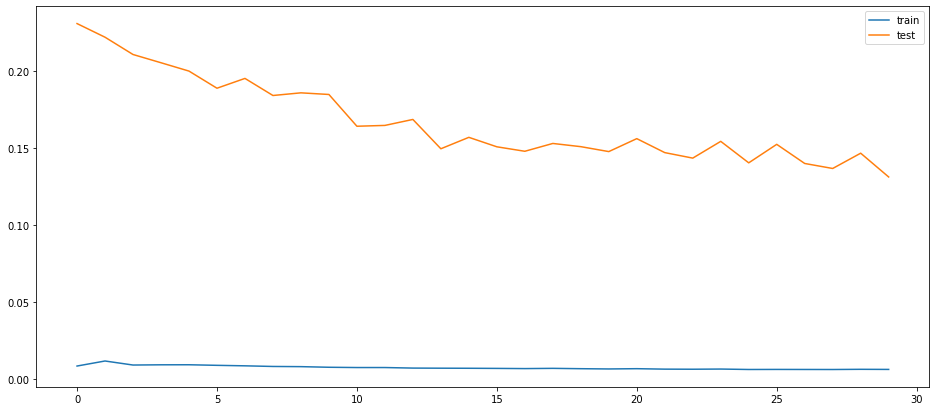

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.legend()
plt.show()

## LSTM Predictions vs. Actual testY

We need to transfer the scale data to the original data (real value), So we are going to use **inverse_transform** to Scale back the data to the original representation.

In [ ]:
predicted_test_data = model.predict(testX)
predicted_test_data = scaler.inverse_transform(predicted_test_data)
test_actual = scaler.inverse_transform(testY.reshape(-1, 1))

difference between Predictions and Actual

In [ ]:
l = zip(predicted_test_data,test_actual)
m = map(lambda x: x[0]-x[1], l)
r = reduce(lambda x,y: x + y, m)
print("result of Predictions - Actual testY:", r)

result of Predictions - Actual testY: [41453767.4974221]


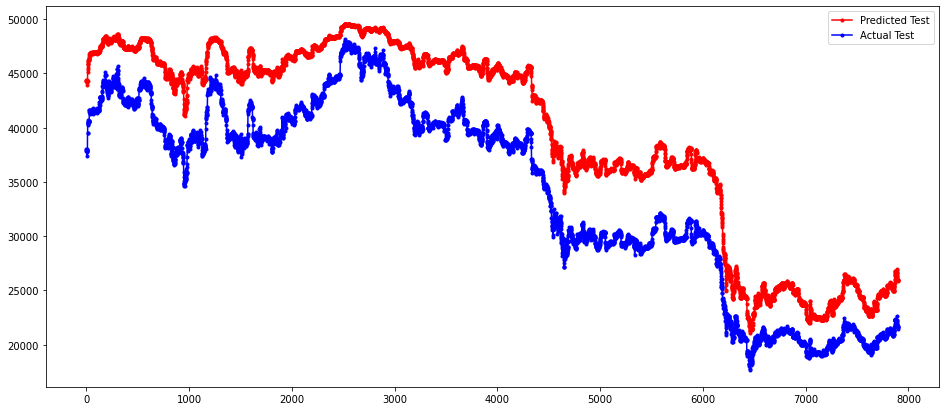

In [ ]:
plt.figure(figsize=(16,7))

plt.plot(predicted_test_data, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, 'b', marker='.', label='Actual Test')

plt.legend()
plt.show()

##Mean squared error

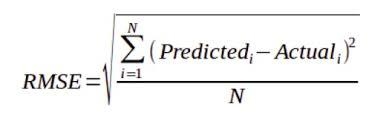

In [ ]:
# Transformation to original form and making the predictions

predicted_btc_price_train_data = model.predict(trainX)

predicted_btc_price_train_data = scaler.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))

train_actual = scaler.inverse_transform(trainY.reshape(-1, 1))

In [ ]:
# Train Data
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))

print('Test RMSE: %.3f' % rmse_lstm_train)

Test RMSE: 5201.127


In [ ]:
# Test Data
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)

Test RMSE: 5410.169
